# Using Rotations with `mag2exp`
`discretisedfield` objects have the functionality to be rotated. We can make use of this functionality with the `mag2exp` package.

This is an example of how to use the rotation functionality with Lorentz Transmission Electron Microscopy (LTEM) in order to view Néel magentisation structures. This tutorial assumes knowledge of how to use the `FieldRotator` class and `mag2exp.ltem`. Tutorials on both of these topics can be found in their relevant documentation.

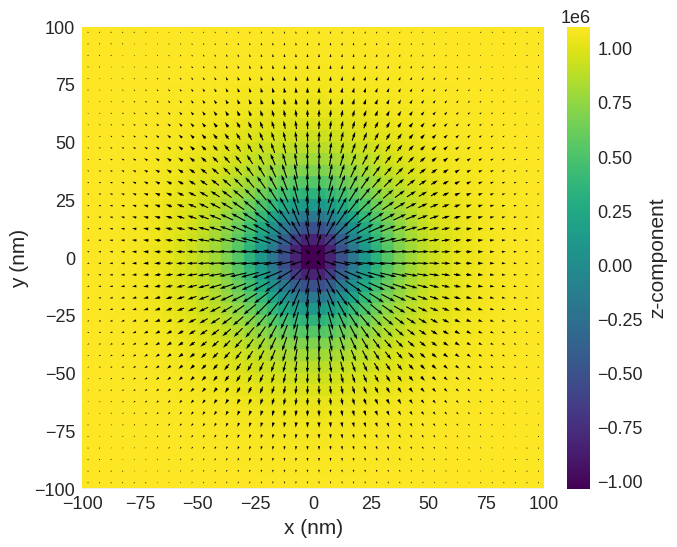

In [1]:
import discretisedfield as df
import matplotlib.pyplot as plt
import micromagneticmodel as mm
import numpy as np
import oommfc as oc

region = df.Region(p1=(-100e-9, -100e-9, -100e-9), p2=(100e-9, 100e-9, 100e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))


system = mm.System(name="Box2")

system.energy = (
    mm.Exchange(A=1.6e-11)
    + mm.DMI(D=4e-3, crystalclass="Cnv_z")
    + mm.Zeeman(H=(0, 0, 2e5))
)

Ms = 1.1e6


def rho_func(r, s_size):
    t = np.pi * np.exp(
        -r / s_size
    )  # Change this function for differnt out of plane functions
    return t


def phi_func(n_top, a, g):
    p = n_top * a + g
    return p


def m_fun_2(pos):
    x, y, z = pos
    phase = 0
    n_top = 1
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    phi = phi_func(n_top, theta, phase)
    rho = rho_func(r, 30e-9)
    return (np.cos(phi) * np.sin(rho), np.sin(phi) * np.sin(rho), np.cos(rho))


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_fun_2, norm=Ms)
system.m.sel("z").mpl()

Relax the system and plot its magnetisation.

Running OOMMF (ExeOOMMFRunner)[2023/10/18 12:09]... (0.6 s)


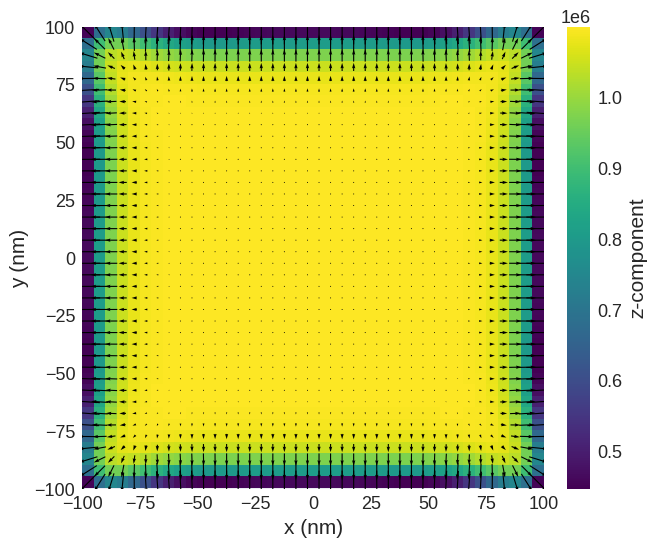

In [2]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

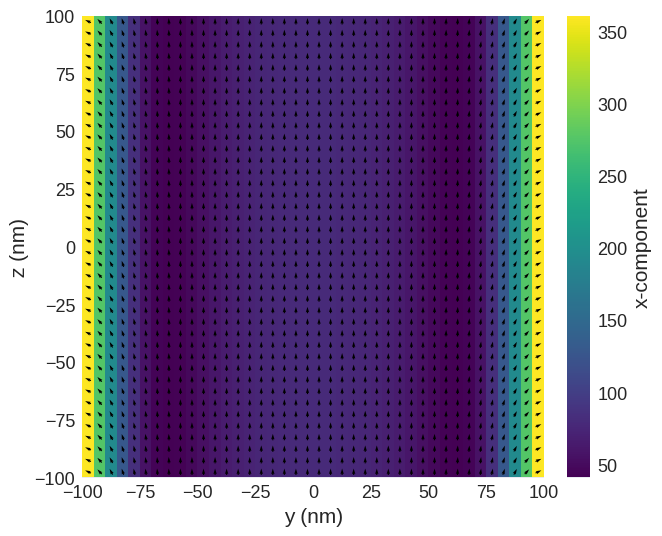

In [3]:
system.m.sel("x").mpl()

Here we have a Néel Skyrmion in a box.

## Computing LTEM images
We can use the `quick_plots` functionality of the `mag2exp` package to plot a defocused image of this magnetisation structure.

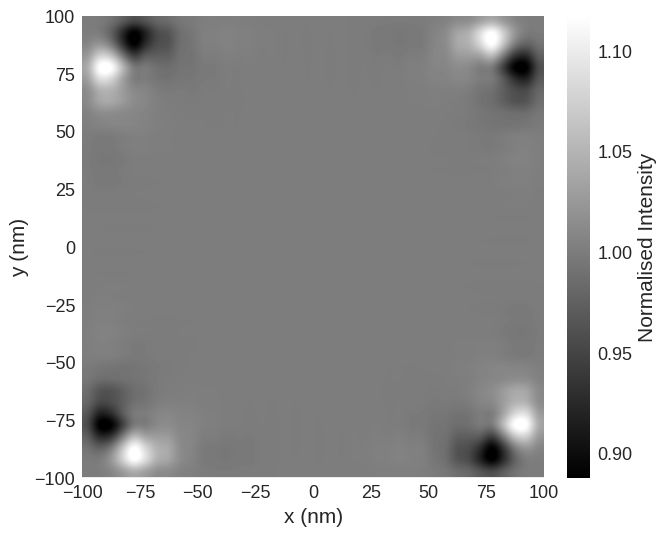

In [4]:
import mag2exp

mag2exp.quick_plots.ltem_defocus(system.m, voltage=300e3)

It can be seen that the the contrast originates from the corners of the sample rather than the Néel skyrmion. This is because in Néel magnetisation textures, the symmetry of the system means that when an electron is deflected due to the Lorentz force, there is usually another electron that deflected to the position of the original electron. This means that there is no overall contrast. 

To break this symmetry, we can rotate the sample in space, thus creating additional contrast. Firstly we can create a `FieldRotator` of our field.

In [5]:
field_rotator = df.FieldRotator(system.m)

We can then apply rotations of 5 degrees about the $y$ axis, plotting the defocused pattern that is created.

10 degree rotation


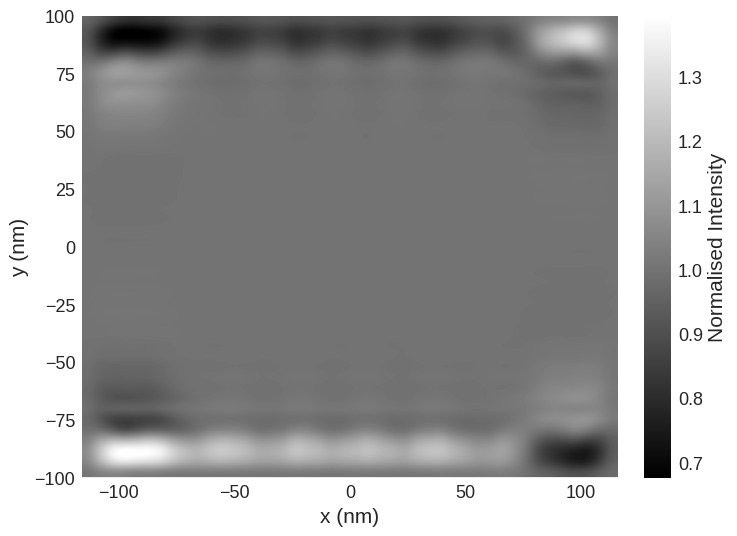

20 degree rotation


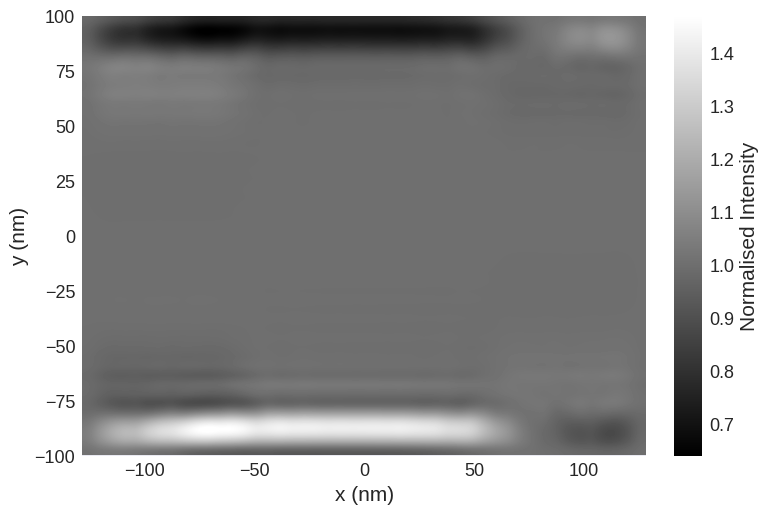

30 degree rotation


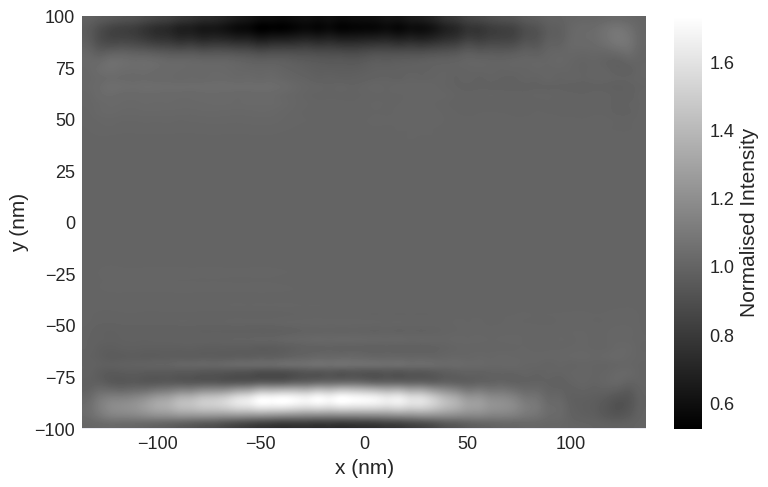

40 degree rotation


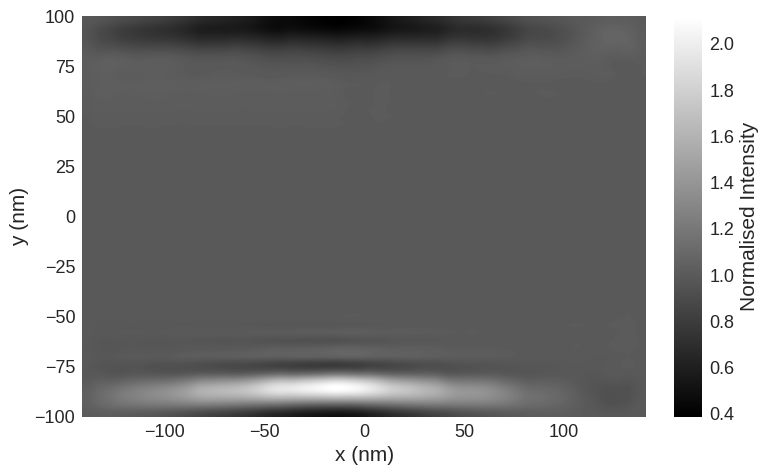

50 degree rotation


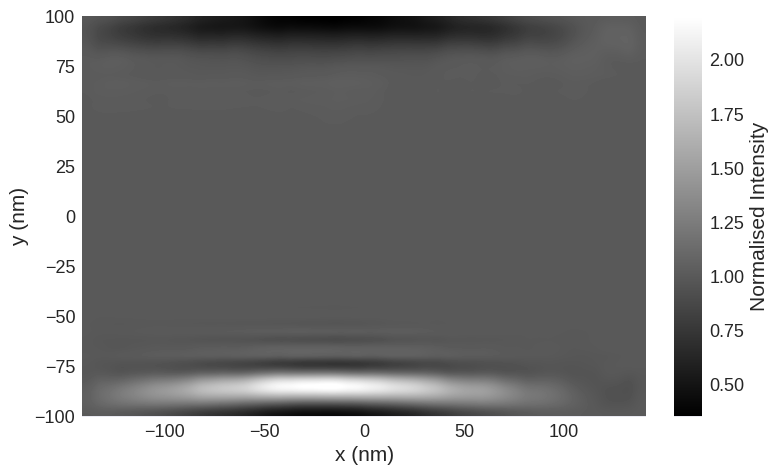

In [6]:
angle = 0
for i in range(5):
    field_rotator.rotate("from_euler", seq="y", angles=10, degrees=True)
    angle += 10
    print(f"{angle} degree rotation")
    mag2exp.quick_plots.ltem_defocus(field_rotator.field, voltage=300e3)
    plt.show()

We can use any of the available rotation methods to rotate the magnetisation. Here we can see the both the contrast from the skyrmion and also from the edges of the cube.

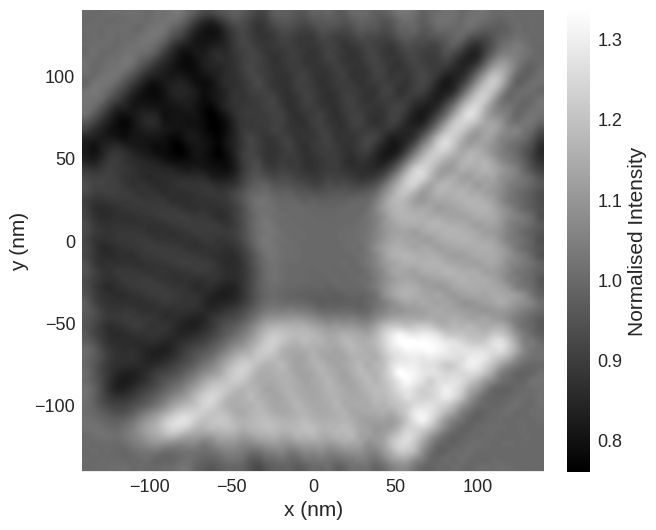

In [7]:
field_rotator.clear_rotation()
field_rotator.rotate("align_vector", initial=[0, 0, 1], final=[1, 1, 2])
mag2exp.quick_plots.ltem_defocus(field_rotator.field, voltage=300e3)